In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score,roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

In [2]:
pd.options.display.max_colwidth = 280

In [3]:
# read in the trian and the test csv
df = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
# checking the class distribution
df.target.sum()/df.shape[0]

0.4296597924602653

### nlp functions

In [6]:
def text_normalization(series):
    # normalization of the text and replacing any hastags and nonalphanumeric chars
    temp = series.str.lower()
    temp = temp.str.replace('[^a-zA-Z0-9, ]', '')
    temp = temp.str.split()
    # removing the stopwords in the text and turning the entry to a list of words
    stop = stopwords.words('english')
    temp = temp.apply(lambda words: [word for word in words if word not in stop])
    return temp

In [7]:
def load_glove(filename):
    """
    Read all lines from the indicated file and return a dictionary
    mapping word:vector where vectors are of numpy `array` type.
    GloVe file lines are of the form:

    the 0.418 0.24968 -0.41242 0.1217 ...

    So split each line on spaces into a list; the first element is the word
    and the remaining elements represent factor components. The length of the vector
    should not matter; read vectors of any length.
    """

    #open and read in the files in lines
    with open(filename, 'r') as f:
        word_vecs = f.readlines()

    #create the dictionary where the word is key and the value is the word vector
    mapping = {}
    for word_vec in word_vecs:
        temp = word_vec.split()
        mapping[temp[0]] = np.array(temp[1:], dtype = float)
    return mapping

In [8]:
word_dict = load_glove('../glove.twitter.27B/glove.twitter.27B.100d.txt')

In [9]:
def avg_doc2vec(text, gloves=word_dict):
    """
    Return the average word vector for the tweet. Sum the word vectors
    for each word and then divide by the number of words. Ignore words
    not in gloves.
    """
    
    vec = np.zeros(len(text))
    # flag for if its the first word
    flag = 1
    # iterate through the list of words to sum up the word vectors in the doc
    for word in text:
        if word in gloves.keys():
            if flag == 1:
                vec = gloves[word]
                flag = 0
            else:
                vec = np.add(vec, gloves[word])

    # return the average vector
    return vec/len(text)

In [10]:
def create_data(dataframe, length):
    """turning the series of word embedding vectors into a nd array."""
    X = np.empty([dataframe.shape[0], length])
    y = np.empty([dataframe.shape[0]])
    for idx, row in dataframe.iterrows():
        try:
            X[idx, :] = row.text
        except:
            X[idx, :] = np.zeros(length)
        y[idx] = row.target
    return (X, y)

### Logistic Regression (100d word embeddings)

In [11]:
# normalizing the text and creating an average doc2vec
#df = pd.read_csv("../data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(avg_doc2vec)
# creating the data and splitting it
X, y = create_data(df, 100)
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
# trying a logistic regression
log = LogisticRegression(solver='lbfgs', max_iter=200)
log.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
# evaluation metrics w/ 100d
print(f"Training Accuracy w/ Logistic Regression: {accuracy_score(y_train, log.predict(X_train))}")
print(f"Testing Accuracy w/ Logistic Regression: {accuracy_score(y_test, log.predict(X_test))}")

Training Accuracy w/ Logistic Regression: 0.8004904536696444
Testing Accuracy w/ Logistic Regression: 0.7883403361344538


In [15]:
# evaluation metrics w/ 100d
print(f"Training F1-Score w/ Logistic Regression: {f1_score(y_train, log.predict(X_train))}")
print(f"Testing F1-Score w/ Logistic Regression: {f1_score(y_test, log.predict(X_test))}")

Training F1-Score w/ Logistic Regression: 0.7546844712470385
Testing F1-Score w/ Logistic Regression: 0.7405022537025112


In [23]:
log_fpr, log_tpr, thresholds = roc_curve(y_train, log.predict_proba(X_train)[:,1])

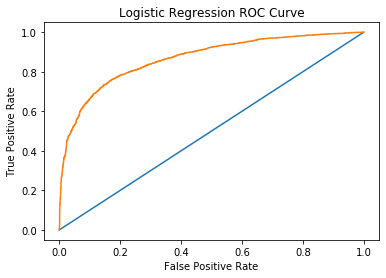

In [24]:
plt.plot([0,1], [0,1])
plt.plot(log_fpr, log_tpr)
plt.title('Logistic Regression ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [25]:
print(f"Training AUC Score: {roc_auc_score(y_train, log.predict_proba(X_train)[:,1])}")
print(f"Testing AUC Score: {roc_auc_score(y_test, log.predict_proba(X_test)[:,1])}")

Training AUC Score: 0.8670792037700611
Testing AUC Score: 0.8565327633111346


### Out of Sample

In [28]:
def create_sub(dataframe, length):
    # turning the series of word embedding vectors into a nd array
    X = np.empty([dataframe.shape[0], length])
    y = np.empty([dataframe.shape[0]])
    for idx, row in dataframe.iterrows():
        try:
            X[idx, :] = row.text
        except:
            X[idx, :] = np.zeros(length)
    return X

In [29]:
# normalizing the text and creating an average doc2vec
df = pd.read_csv("../data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(avg_doc2vec)
# creating the data and splitting it
X, y = create_data(df, 100)

In [30]:
test = pd.read_csv("../data/test.csv")
test['text'] = text_normalization(test.text)
test['text'] = test.text.apply(avg_doc2vec)
X_test = create_sub(test, 100)

In [31]:
# trying a logistic regression
log = LogisticRegression(solver='lbfgs', max_iter=200)
log.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
# evaluation metrics w/ 100d
print(f"Training Accuracy w/ Logistic Regression: {accuracy_score(y, log.predict(X))}")
print(f"Training F1-Score w/ Logistic Regression: {f1_score(y, log.predict(X))}")
print(f"Training AUC Score w/ Logistic Regression: {roc_auc_score(y, log.predict_proba(X)[:,1])}")

Training Accuracy w/ Logistic Regression: 0.7987652699330093
Training F1-Score w/ Logistic Regression: 0.7525839793281655
Training AUC Score w/ Logistic Regression: 0.8657637691247329


In [33]:
final = pd.DataFrame({'id': test.id.values, 'target': log.predict(X_test)})
final['target'] = final.target.astype('int64')
final

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [35]:
final.to_csv('DAM_sub_100d.csv', index=False)

### SVC (Linear)

In [41]:
svc = LinearSVC(max_iter=1500)
svc.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [43]:
# evaluation metrics w/ 100d
print(f"Training Accuracy w/ SVC: {accuracy_score(y, svc.predict(X))}")
print(f"Training F1-Score w/ SVC: {f1_score(y, svc.predict(X))}")
#print(f"Training AUC Score w/ SVC: {roc_auc_score(y, svc.predict_proba(X)[:,1])}")

Training Accuracy w/ SVC: 0.797583081570997
Training F1-Score w/ SVC: 0.7485723609071626


### SVC (Hyperparameters Tuning) <- Best Model so far

In [146]:
# normalizing the text and creating an average doc2vec
df = pd.read_csv("../data/train.csv")
df['text'] = text_normalization(df.text)
df['text'] = df.text.apply(avg_doc2vec)
# creating the data and splitting it
X, y = create_data(df, 100)

In [187]:
test = pd.read_csv("../data/test.csv")
test['text'] = text_normalization(test.text)
test['text'] = test.text.apply(avg_doc2vec)
X_test = create_sub(test, 100)

In [184]:
svc = SVC(max_iter=3000, gamma='scale')
params_grid = {'C': np.logspace(-4, 5, 8),
               'kernel': ['linear', 'rbf']}

grid = GridSearchCV(estimator=svc, scoring='f1',
                    n_jobs=4, param_grid=params_grid,
                    cv=5)

In [185]:
grid.fit(X, y)
grid.best_params_

/Users/dillonquan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'C': 0.7196856730011528, 'kernel': 'rbf'}

In [180]:
grid.best_score_

0.7369265896389726

In [186]:
svc = SVC(max_iter=4000, gamma='scale', C=0.7196856730011528, kernel='rbf')
svc.fit(X, y)

SVC(C=0.7196856730011528, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=4000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [188]:
final = pd.DataFrame({'id': test.id.values, 'target': svc.predict(X_test)})
final['target'] = final.target.astype('int64')
final

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [191]:
ground = pd.read_csv('../submissions/gt.csv')

In [194]:
final[final['target'] == ground['target']].shape[0]/final.shape[0]

0.8020226785167024

In [195]:
final.to_csv('../DAM_sub_svc_tuned.csv', index=False)

In [196]:
final.shape

(3263, 2)

In [197]:
ground.shape

(3263, 2)

### Logistic Regression Tuning

In [173]:
log = LogisticRegression(solver='saga', max_iter=200, penalty='elasticnet')
params_grid = {'C': np.logspace(-5, 6, 8),
               'l1_ratio': np.linspace(0, 1, 10)}

log_grid = GridSearchCV(estimator=log, scoring='f1',
                    param_grid=params_grid, cv=5,
                    n_jobs=4)

In [174]:
log_grid.fit(X, y)
log_grid.best_params_

{'C': 0.5179474679231213, 'l1_ratio': 0.3333333333333333}

In [175]:
log = LogisticRegression(solver='saga', max_iter=200,
                         C=0.5179474679231213, penalty='elasticnet',
                         l1_ratio=0.3333333333333333)
log.fit(X, y)

LogisticRegression(C=0.5179474679231213, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1,
                   l1_ratio=0.3333333333333333, max_iter=200,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [176]:
final = pd.DataFrame({'id': test.id.values, 'target': log.predict(X_test)})
final['target'] = final.target.astype('int64')
final

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [177]:
final[final['target'] == ground['target']].shape[0]/final.shape[0]

0.7836346920012258